# Proyecto Mecardos de CMDX
Andrés Urbano Guillermo Gerardo

Como mencionamos en nuestro documentro técnico y ejecutivo, queremos fomentar el turismo en los mercados de la Ciudad de México y ayudar a los provedores a llevar la mercancia en tiempo y forma a los mercados de las diferentes delegaciones. Para necesitamos encontrar la ruta de ayude a pasar a cada uno de los mercados sin tener que volver a pasar por el mismo.

Primero importaremos nuestras bibliotecas:

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx 
import sympy as sp
import matplotlib.pyplot as plt

Leemos nuestro conjunto de datos: 
(Conjunto extraido de: https://datos.cdmx.gob.mx/dataset/mercados-publicos)


In [284]:
df = pd.read_csv('mercadosCDMX.csv')
df.tail()

,N°,DELEGACION,MERCADO,NUM_OFIC,NUM_LOCALE,Coord_Y,Coord_X,DIRECCION,COLONIA,TIPO,SUPERF_M2,INAUGURACI,ANTIGÜEDA,VOCACIÓN,DETALLE,FORMA,NIVELES,TAMAÑO1,PROTEGIDO,COORGEOG_Y,COORGEOG_X
324,165,GUSTAVO A. MADERO,24 DE SEPTIEMBRE,365.000,78,2.153350e+06,493394.265379,RET. TREBOL TULLA Y PITACANTO,U.H. PRADERA,TRADICIONAL,1644,1981,39,N/D,N/D,CUADRO,1,CHICO,NO,-99.062943,19.474659
325,274,TLALPAN,VEINTICUATRO DE FEBRERO,0.394,53,2.131232e+06,476307.622623,"F.F. C.C. CUERNAVACA, ENTRE TULUN Y PROL. TEKIL",LOMAS DE PADIERNA SUR,TRADICIONAL,460,1989,31,N/D,N/D,CUADRO,1,CHICO,NO,-99.225478,19.274643
326,300,VENUSTIANO CARRANZA,MERCED PASO A DESNIVEL,103.000,77,2.147924e+06,487046.161235,ROSARIO Y ADOLFO GURRION COL. MERCED CENTRO,MERCED CENTRO,ESPECIALIZADO,2100,1957,63,"MUEBLES, FERRETERÍA, JACIERÍA, MIMBRE, CESTERÍ...","JARCIERIA, CESTERIA Y MIMBRE",RECTANGULO,1,CHICO,SI,-99.123394,19.425589
327,301,VENUSTIANO CARRANZA,MERCED PASO A DESNIVEL GOMEZ PEDRAZA,241.000,67,2.147716e+06,487039.188724,ROSARIO Y ADOLFO GURRION COL. MERCED CENTRO,MERCED CENTRO,ESPECIALIZADO,2100,1969,51,N/D,N/D,RECTANGULO,1,CHICO,SI,-99.123459,19.423712
328,0,GUSTAVO A. MADERO,PROVIDENCIA,136.000,193,2.154381e+06,492568.961300,"ESTADO DE ZACATECAS, ENTRE ESTADO DE MORELOS Y...",PROVIDENCIA,TRADICIONAL,4978,1986,34,N/D,N/D,RECTANGULAR,1,CHICO,NO,-99.070745,19.484384


Primero haremos un caso particular en una delegación, para despues hacer un caso general para cada uno de los mercados de las diferentes delegaciones:

Exploraremos primero los mercados de Coyoacan

In [286]:
df_mercados_coyoacan =  df[df['DELEGACION'] == 'COYOACÁN']

Utilizaremos la idea de programación Orientada a Objetos para abstraer la información más importante para nuestro problema, en nuestro caso, crearemos una clase Mercado que contendra las coordenadas geograficas del mercado, como su respectivo nombre:

In [ ]:
class Mercado:

    def __init__(self, nombre, delegacion, coor_x, coor_y):
        self.nombre = nombre
        self.delegacion = delegacion
        self.coor_x = coor_x
        self.coor_y = coor_y


    def __str__(self):
        str_mer = 'Delegacion: {}, Mercado {}, Ubica:({}, {})'.format(self.delegacion,
                                                               self.nombre,
                                                               self.coor_x,
                                                               self.coor_y)
        return str_mer 

    def __repr__(self):
        return 'Mercado:{}, Ubicacion:({},{})'.format(self.nombre, self.coor_x, self.coor_y)

    def __eq__(self, otro_mercado):
        return self.nombre == otro_mercado.nombre

Podemos apreciar los diferentes mercados de la delegación de Coyoacán:

In [288]:
nombre_mercado = df_mercados_coyoacan['MERCADO'].values
print('Mercados Coyoacan:\n', nombre_mercado)

Mercados Coyoacan:
 ['COYOACAN' 'PRADO CHURUBUSCO' 'SANTA URSULA COAPA (PESCADITOS)'
 'EL RELOJ' 'XOTEPINGO' 'CHURUBUSCO' 'AVANTE' 'RUIZ CORTINEZ (LA CRUZ)'
 'AJUSCO MONTSERRAT (LA BOLA)' 'SAN FRANCISCO CULHUACAN'
 'AJUSCO MOCTEZUMA' 'EDUCACION PETROLERA' 'LOS REYES COYOACAN'
 'SANTO DOMINGO LAS ROSAS' 'CARMEN SERDAN' 'MARGARITA MAZA DE JUAREZ'
 'EMILIANO ZAPATA' 'SANTO DOMINGO LOS REYES' 'COPILCO EL ALTO'
 'HERMOSILLO' 'EL VERDE' 'BAZAR DEL ARTESANO MEXICANO']


Usamos nuestra clase para crear nuestro objetos Mercados iterando por cada uno de los atributos del dataframe:

In [289]:
mercados_coyoacan = []
for nomb, dele, x, y in zip(df_mercados_coyoacan['MERCADO'], df_mercados_coyoacan['DELEGACION'],
                   df_mercados_coyoacan['COORGEOG_X'], df_mercados_coyoacan['COORGEOG_Y']):
    
    mercado = Mercado(nomb, dele, x, y)
    mercados_coyoacan.append(mercado)    

In [291]:
mercados_coyoacan

[Mercado:COYOACAN, Ubicacion:(19.3527349151,-99.16149799989999),
 Mercado:PRADO CHURUBUSCO, Ubicacion:(19.3540979151,-99.125975),
 Mercado:SANTA URSULA COAPA (PESCADITOS), Ubicacion:(19.3117739152,-99.15033699989999),
 Mercado:EL RELOJ, Ubicacion:(19.3186839152,-99.14053199989999),
 Mercado:XOTEPINGO, Ubicacion:(19.3380869151,-99.1445519999),
 Mercado:CHURUBUSCO, Ubicacion:(19.3497769151,-99.1470619999),
 Mercado:AVANTE, Ubicacion:(19.3261629152,-99.1349329999),
 Mercado:RUIZ CORTINEZ (LA CRUZ), Ubicacion:(19.3187239152,-99.1513459999),
 Mercado:AJUSCO MONTSERRAT (LA BOLA), Ubicacion:(19.3238169152,-99.1574639999),
 Mercado:SAN FRANCISCO CULHUACAN, Ubicacion:(19.3360439151,-99.1233089999),
 Mercado:AJUSCO MOCTEZUMA, Ubicacion:(19.3130269153,-99.1623249999),
 Mercado:EDUCACION PETROLERA, Ubicacion:(19.3363029151,-99.1318449999),
 Mercado:LOS REYES COYOACAN, Ubicacion:(19.3335259151,-99.1579439999),
 Mercado:SANTO DOMINGO LAS ROSAS, Ubicacion:(19.330956915199998,-99.1629299999),
 Mercado

El paso correspondientes es sacar las diferentes distancias entre los mercados, para eso tendremos que utilizar la API de Google para generar una matriz de distancias, en nuestro caso, dado que google pide una suscripción con tarjeta de credito para usar sus servicios, mejor decidi utilizar otra alternativa con una biblioteca llamada `geodesic` que nos dara distancias segun su ubicación en coordenadas geografias. Esta seria una buena aproximación en analogo a la API de Google, ya que lo importante es conseguir los pesos en nuestra gráfica, nos enfocaremos hacer el modelo y el algortimo, dado que si funciona el algoritmo con cualquier distancia, tiempo  o cualquier matriz que valide el peso de grafica con sus respectivas aristas, funcionará para cualquier entrada, siendo independiente del algortimo.

Definimos nuestra función para calcular la entrada:

In [ ]:
from geopy.distance import geodesic

def obtener_distancia(mercado1, mercado2):
    """Obtiene la distancia entre dos mercados"""
    origen = (str(mercado1.coor_x) + ',' + str(mercado1.coor_y))    
    target = (str(mercado2.coor_x) + ',' + str(mercado2.coor_y))
    return geodesic(origen,target).kilometers

Una vez definido nuestra función que sacara la distancia entre 2 mercados, tendremos que sacar ahora la matriz de distancia de todos los mercados, esto nos llevaria un tiempo de complejidad de $O(n^2)$, utilizaremos heuristicas de optmización aprovechando la simetria de la matriz, ya que en nuestro proble el qir de A a B y de B a A será el mismo camino. Con esto los calculos se reduciran a la mitad, calculando solamente la matriz superior de nuestra matriz, y la diagonal principal que estará llena de infinitos dado que no queremos que interfiera en nuestro analisis:

In [292]:
def crear_matriz_distancias(mercados):
    """Crea una matriz de distancias"""
    matriz_distancias = np.zeros((len(mercados), len(mercados)))
    for i, mercado1 in enumerate(mercados):
        for j, mercado2 in enumerate(mercados):            
            
            if mercado1 == mercado2:
                dist_ = float('inf')
                matriz_distancias[i][j] = dist_                                         
                continue                                                 
            # Aprovechando la simetria
            if j > i :                
                dist_ = obtener_distancia(mercado1, mercado2)            
                matriz_distancias[i][j] = dist_                
                matriz_distancias[j][i] = dist_
                
    return matriz_distancias

In [293]:
matriz_distancias = crear_matriz_distancias(mercados_coyoacan)
print(matriz_distancias.shape)
print(type(matriz_distancias))

(22, 22)
<class 'numpy.ndarray'>


In [294]:
display(sp.Matrix(matriz_distancias))

Matrix([
[               oo, 3.73536912944363,  4.68344476039939, 4.36592684588925, 2.40823628768845, 1.55171875585605, 4.05507593190564,  3.91309913466571,  3.22905378481695, 4.41759146321325, 4.39637883159359, 3.60783386634958,  2.15890577919708,  2.41543274514229,   6.8402990986345,  6.60198122107803,  6.76068603363294,  3.7366311359878,  2.50941749153656, 3.55381824112067,  7.37346642731989, 0.350918738519952],
[ 3.73536912944363,               oo,  5.33888217287587, 4.20804881284876, 2.63652848645253, 2.26662680067492, 3.23238267181506,  4.73714025488441,  4.70996705812556, 2.01804628688604, 5.93798357262618, 2.06414213756759,  4.05825456116151,  4.65186662321572,  4.28229166421406,  4.69865186158578,  4.50557834757146, 5.89304715672306,  5.30632750149807, 0.93350856124446,  4.94230195592746,  3.96290948658822],
[ 4.68344476039939, 5.33888217287587,                oo, 1.28330349385826, 2.97550723977995, 4.22083532373901, 2.27102287075826, 0.776609510282193,  1.52910274233594, 3.90

### Grafianco nuestro mercados

Ahora que conocemos el peso de las aristas procederemos a graficar nuestros mercados mediante una gráfica. Creamos una función que construya un dataframe de cualquier mercado:

In [295]:
def crear_dataframe_mercados(mercados, matriz_distancias):
    """Creación de dataframe para una grafica"""    
    nombres_mercado1 = []
    nombres_mercado2 = []
    distancias = []
    for i, mercado1 in enumerate(mercados):
        for j, mercado2 in enumerate(mercados):                          
            # Aprovechando la simetria
            if j > i and mercado1 != mercado2:                
                nombres_mercado1.append(mercado1.nombre)
                nombres_mercado2.append(mercado2.nombre) 
                distancias.append(matriz_distancias[i][j])    
    data = {'source': nombres_mercado1, 'target': nombres_mercado2, 'weight': distancias}    
    dataframe = pd.DataFrame(data)
    return dataframe

Probamos nuestra función con la delegación de Coyoacan:

In [296]:
df_coyoacan = crear_dataframe_mercados(mercados_coyoacan, matriz_distancias)
df_coyoacan.head(5)

,source,target,weight
0,COYOACAN,PRADO CHURUBUSCO,3.735369
1,COYOACAN,SANTA URSULA COAPA (PESCADITOS),4.683445
2,COYOACAN,EL RELOJ,4.365927
3,COYOACAN,XOTEPINGO,2.408236
4,COYOACAN,CHURUBUSCO,1.551719


Graficamos cada mercado:

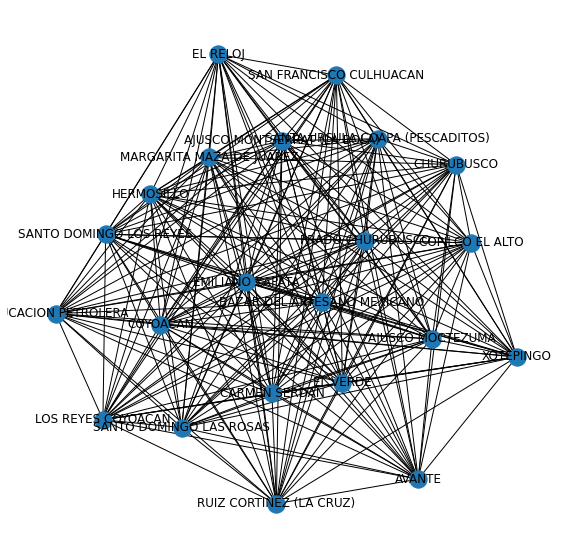

In [297]:
G = nx.Graph()   
for o, t, w in zip(df_coyoacan['source'], df_coyoacan['target'], df_coyoacan['weight']):
    G.add_weighted_edges_from([(o,t,w)])

fig, ax = plt.subplots(figsize=(10,10))
nx.draw(G, with_labels=True, ax=ax)
#plt.savefig('coyoacan')

En esta grafica podemos apreciar todos los mercados de Coyoacan de la Ciudad de México.

Podemos ver también el peso de cada una de las aristas:

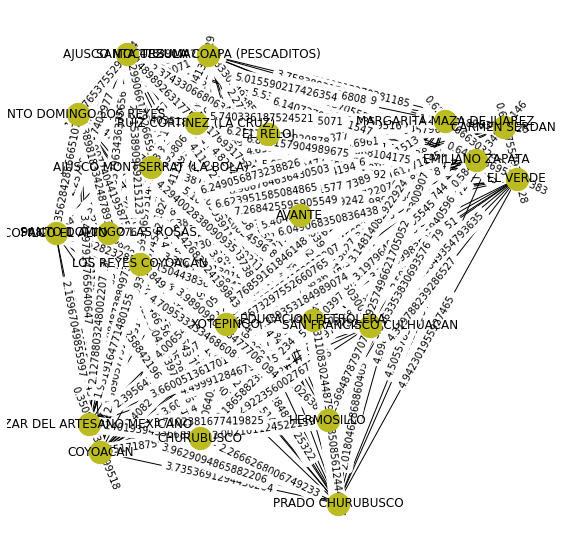

In [ ]:
KKL=nx.kamada_kawai_layout(G)
labels = nx.get_edge_attributes(G,'weight')

fig, ax= plt.subplots(1)
fig.set_size_inches(10,10)
nx.draw_kamada_kawai(G,ax=ax,with_labels=True, node_color='#bbbb22',node_size=500)
nx.draw_networkx_edge_labels(G,KKL,ax=ax,edge_labels=labels)
plt.show()
#print("El camino más corto del vértice 7 al 17 es {} y pesa {}".format(D[1],D[0]))

## Algortimo Greedy 

Utilizaremos un algoritmo greedy como mencionamos en el documento, ya que tiene un tiempo de complejidad polinomial $O(n^2)$ que puede verse lineal cuando tenemos un conjunto de entrada pequeños, en nuestro, nuestro conjunto de entrada corresponde a los mercados de cada delagación lo cual no pasan de 50, probaremos este algoritmo y veremos los resultados: 

```
Algortimo
1.- Ir al nodo más cercano no visitado (menor coste)
2.- Si es el último, regresar a casa
3.- Empezar en 0.
```


In [298]:
def ruta_optima_greedy(nodo_inicial, G):
    n_node = G.number_of_nodes() - 1
    ruta_optima = []
    nodos_visitados = []
    nodos_visitados.append(nodo_inicial)
    while(n_node != 0):
        peso_minimo = float("inf")
        nodo_siguiente = None        
        for vecino, peso in G.adj[nodo_inicial].items():
            if peso['weight'] < peso_minimo and vecino not in nodos_visitados:
                peso_minimo = peso['weight'] 
                nodo_siguiente = vecino
        
        ruta_optima.append((nodo_inicial, nodo_siguiente, round(peso_minimo, 3)))
        nodos_visitados.append(nodo_siguiente)
        nodo_inicial = nodo_siguiente        
        n_node -= 1
    return ruta_optima       

Veremos la ruta que nos ha marcado: 

In [ ]:
ruta_optima = ruta_optima_greedy('COYOACAN', G)
print(ruta_optima)

[('COYOACAN', 'BAZAR DEL ARTESANO MEXICANO', 0.351), ('BAZAR DEL ARTESANO MEXICANO', 'CHURUBUSCO', 1.724), ('CHURUBUSCO', 'XOTEPINGO', 1.321), ('XOTEPINGO', 'EDUCACION PETROLERA', 1.35), ('EDUCACION PETROLERA', 'SAN FRANCISCO CULHUACAN', 0.897), ('SAN FRANCISCO CULHUACAN', 'HERMOSILLO', 1.226), ('HERMOSILLO', 'PRADO CHURUBUSCO', 0.934), ('PRADO CHURUBUSCO', 'AVANTE', 3.232), ('AVANTE', 'EL RELOJ', 1.016), ('EL RELOJ', 'RUIZ CORTINEZ (LA CRUZ)', 1.136), ('RUIZ CORTINEZ (LA CRUZ)', 'SANTA URSULA COAPA (PESCADITOS)', 0.777), ('SANTA URSULA COAPA (PESCADITOS)', 'AJUSCO MOCTEZUMA', 1.267), ('AJUSCO MOCTEZUMA', 'SANTO DOMINGO LOS REYES', 1.002), ('SANTO DOMINGO LOS REYES', 'AJUSCO MONTSERRAT (LA BOLA)', 1.273), ('AJUSCO MONTSERRAT (LA BOLA)', 'SANTO DOMINGO LAS ROSAS', 0.977), ('SANTO DOMINGO LAS ROSAS', 'LOS REYES COYOACAN', 0.596), ('LOS REYES COYOACAN', 'COPILCO EL ALTO', 1.352), ('COPILCO EL ALTO', 'MARGARITA MAZA DE JUAREZ', 6.249), ('MARGARITA MAZA DE JUAREZ', 'EMILIANO ZAPATA', 0.629)

Graficaremos esta ruta:

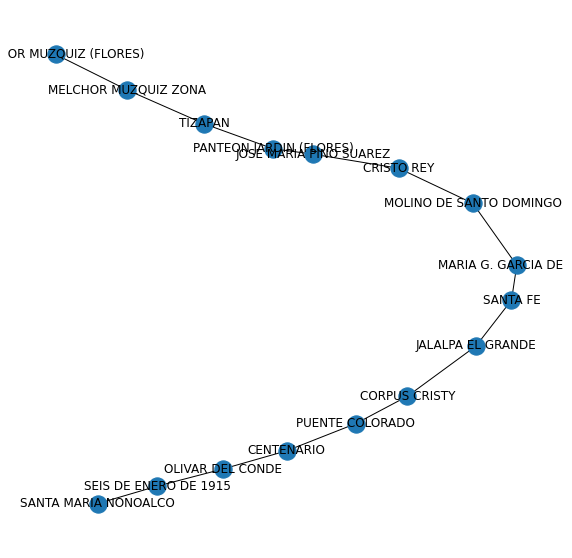

In [299]:
G_ruta_optima = nx.Graph()   
G_ruta_optima.add_weighted_edges_from(ruta_optima)
fig, ax = plt.subplots(figsize=(10,10))
nx.draw(G_ruta_optima, with_labels=True, ax=ax)
#plt.savefig('coyoacan')

Definimos una funciona que nos calcule cuanto es la distancia a recorrer en total por cada mercado: 

In [ ]:
def obtener_peso_total(G):
    """Obtiene el peso de una grafica ponderada"""
    lista_aristas = G.edges.data('weight')
    peso_total = 0
    for arista in lista_aristas:
        _, __, w = arista
        peso_total += w
    return peso_total

Ruta optima con el algortimo greedy en la delegación de coyoacan: 

In [ ]:
obtener_peso_total(G_ruta_optima)

28.561999999999998

Si bien esta ruta podria no ser la optima, debido a que toma sólo los mejores pesos en el momento, sin considerar el pasodo o futuro como otros algortimo, pero nos da una aproximación a una ruta en tiempo relativamente rápido por el tamaño de nuestra entrada, enseguido mostraremos un algortimo con la metodologia de backtracking.

### Backtracking

Utilizar backtracking nos pueda mejores resultado ya que obtedremos todos los posibles caminos, pero esto nos lleva a explorar por fuerta bruta todo el conjunto del espacio estado y esto puede provocar una complejidad elevada en tiempo y espacio.


In [300]:
caminos = []
dist_totales = []

def ruta_optima_backtrack(nodo_inicial, G, n,a=[], visitados=[], dist=0):    
    # Significa que ya ha revisado cada arista del grafo (n-1 aristas)
    if len(a) == n-1:        
        #print('Camino: {} distancia total: {}'.format(a, dist))
        caminos.append(a.copy())
        dist_totales.append(dist)        
        return dist        

    candidatos = G.adj[nodo_inicial]
    for vecino, peso in candidatos.items():
        if vecino not in visitados:        
            a.append((nodo_inicial, vecino, peso['weight']))
            visitados.append(nodo_inicial)                 
            ruta_optima_backtrack(vecino, G, n, a, visitados, dist+peso['weight'])
            # Paso hacia atras
            a.remove((nodo_inicial, vecino, peso['weight']))  
            visitados.remove(nodo_inicial)        

Probaremos nuestro algortimo con una grafica con una entrada pequeña para ver su correctitud de nuestro, ya que veremos más adelante que al ejecutar nuestro algortimo con el conjunto de entrada de los mercados puede tomar mucho tiempo.

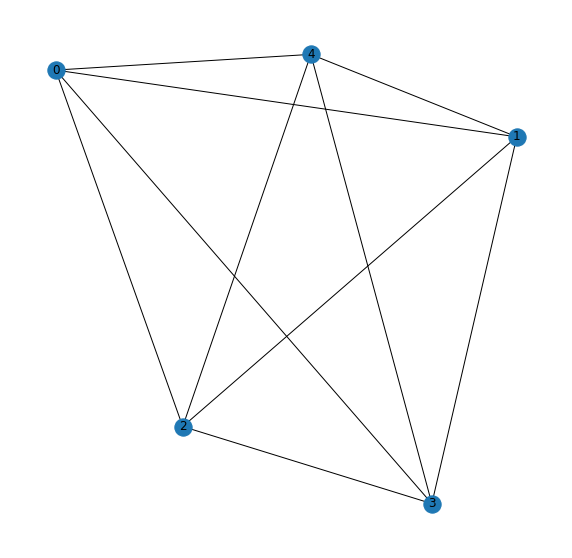

In [301]:
import random
G_ = nx.complete_graph(5)

G_prueba = nx.Graph()   
for o in G_.nodes:
    for t in G_.nodes:
        if o != t:
            w = random.randint(1,5)
            G_prueba.add_weighted_edges_from([(o,t,w)])

fig, ax = plt.subplots(figsize=(10,10))
nx.draw(G_prueba, with_labels=True, ax=ax)

In [303]:
ruta_optima_backtrack(1, G_prueba, G_prueba.number_of_nodes())
for camino, dist in zip(caminos, dist_totales):
    print('Camino: {} distancia total: {}'.format(camino, dist))

Camino: [(1, 0, 1), (0, 2, 3), (2, 3, 2), (3, 4, 3)] distancia total: 9
Camino: [(1, 0, 1), (0, 2, 3), (2, 4, 3), (4, 3, 3)] distancia total: 10
Camino: [(1, 0, 1), (0, 3, 1), (3, 2, 2), (2, 4, 3)] distancia total: 7
Camino: [(1, 0, 1), (0, 3, 1), (3, 4, 3), (4, 2, 3)] distancia total: 8
Camino: [(1, 0, 1), (0, 4, 2), (4, 2, 3), (2, 3, 2)] distancia total: 8
Camino: [(1, 0, 1), (0, 4, 2), (4, 3, 3), (3, 2, 2)] distancia total: 8
Camino: [(1, 2, 2), (2, 0, 3), (0, 3, 1), (3, 4, 3)] distancia total: 9
Camino: [(1, 2, 2), (2, 0, 3), (0, 4, 2), (4, 3, 3)] distancia total: 10
Camino: [(1, 2, 2), (2, 3, 2), (3, 0, 1), (0, 4, 2)] distancia total: 7
Camino: [(1, 2, 2), (2, 3, 2), (3, 4, 3), (4, 0, 2)] distancia total: 9
Camino: [(1, 2, 2), (2, 4, 3), (4, 0, 2), (0, 3, 1)] distancia total: 8
Camino: [(1, 2, 2), (2, 4, 3), (4, 3, 3), (3, 0, 1)] distancia total: 9
Camino: [(1, 3, 3), (3, 0, 1), (0, 2, 3), (2, 4, 3)] distancia total: 10
Camino: [(1, 3, 3), (3, 0, 1), (0, 4, 2), (4, 2, 3)] distanci

Como podemos apreciar arriba genero una gran cantidad de caminos correctamente con un conjunto de entrada pequeño, podemos ver que si metemos una entrada más grade puede llevarnos en tiempo y espacio con una complejida $O(!n)$. Por eso mismo he comentado la linea de abajo, precisamente porque al ejecutarlo la memoria se acaba y nunca termina nuestro programa. Este es un claro ejemplo de lo importante de entender la complejidad algoritmica.

In [ ]:
#ruta_optima_backtrack('COYOACAN', G, G.number_of_nodes())

## Generalizacion para todos los mercados de CDMX

Ahora vamos hacerlo general para todos los mercados de la ciudad de México:

In [304]:
nombres_delegaciones = np.unique(df['DELEGACION'])
print(nombres_delegaciones)

['AZCAPOTZALCO' 'BENITO JUÁREZ' 'COYOACÁN' 'CUAJIMALPA' 'CUAUHTÉMOC'
 'GUSTAVO A. MADERO' 'IZTACALCO' 'IZTAPALAPA' 'MAGDALENA CONTRERAS'
 'MIGUEL HIDALGO' 'MILPA ALTA' 'TLALPAN' 'TLÁHUAC' 'VENUSTIANO CARRANZA'
 'XOCHIMILCO' 'ÁLVARO OBREGÓN']


In [305]:
print('Total de las delegaciones:', len(nombres_delegaciones))

Total de las delegaciones: 16


Creamos una dataframe de todos los mercados: 

In [306]:
df_mercados_cdmx = []
for nombre_delegacion in nombres_delegaciones:
    df_mercados_cdmx.append(df[df['DELEGACION'] == nombre_delegacion])

Creamos un diccionario con los mercados con la metodologia de Orientda objetos para mayor manipulación: 

In [307]:
mercados_cdmx_del = {}
for df_mercado_cdmx, nombre_delegacion in zip(df_mercados_cmdx, nombres_delegaciones):
    mercado_cdmx = []    
    
    for nomb, dele, x, y in zip(df_mercado_cdmx['MERCADO'], df_mercado_cdmx['DELEGACION'],
                   df_mercado_cdmx['COORGEOG_X'], df_mercado_cdmx['COORGEOG_Y']):
        
        mercado = Mercado(nomb, dele, x, y)
        mercado_cdmx.append(mercado)
    #mercados_cdmx_del.append(mercado_cdmx)
    mercados_cdmx_del[nombre_delegacion] = mercado_cdmx

Obtenemos las matrices de distancias para delegación: 

In [309]:
matrices_distancias_del = []
for nombre_delegacion in mercados_cdmx_del.keys():
    matriz_distancias = crear_matriz_distancias(mercados_cdmx_del[nombre_delegacion])
    matrices_distancias_del.append(matriz_distancias)    

Ejemplo de la matriz de distancia para la delegación de Cuajimalpa que solo tiene 5 mercados:

In [ ]:
display(sp.Matrix(matrices_distancias_del[3]))

Matrix([
[               oo, 2.30284112181679,  1.92845176040609,  2.62698153144259, 0.823154706902449],
[ 2.30284112181679,               oo,  3.13286095266663,  3.21910622942607,  2.02308308435367],
[ 1.92845176040609, 3.13286095266663,                oo, 0.885216330701305,  2.69812435827049],
[ 2.62698153144259, 3.21910622942607, 0.885216330701305,                oo,  3.31023991032365],
[0.823154706902449, 2.02308308435367,  2.69812435827049,  3.31023991032365,                oo]])

Convertimos a cada mercado en un dataframe: 

In [ ]:
df_mercados_del_cmdx = {}

for nombre_del, matriz_distancias in  zip(mercados_cdmx_del, matrices_distancias_del):
    df_delegacion = crear_dataframe_mercados(mercados_cdmx_del[nombre_del], matriz_distancias)
    #df_mercados_del_cmdx.append(df_delegacion)
    df_mercados_del_cmdx[nombre_del] = df_delegacion

#df_mercados_cdmx[1]

In [ ]:
print('Nombres delegaciones:', list(df_mercados_del_cmdx.keys()))

Nombres delegaciones: ['AZCAPOTZALCO', 'BENITO JUÁREZ', 'COYOACÁN', 'CUAJIMALPA', 'CUAUHTÉMOC', 'GUSTAVO A. MADERO', 'IZTACALCO', 'IZTAPALAPA', 'MAGDALENA CONTRERAS', 'MIGUEL HIDALGO', 'MILPA ALTA', 'TLALPAN', 'TLÁHUAC', 'VENUSTIANO CARRANZA', 'XOCHIMILCO', 'ÁLVARO OBREGÓN']


Usando esta idea de los diccionarios podemos facilmente accedere a los diferentes mercados por el nombre de la delegación:

In [ ]:
df_mercados_del_cmdx['CUAJIMALPA']

,source,target,weight
0,CUAJIMALPA,SAN MATEO TLALTENANGO,2.302841
1,CUAJIMALPA,ROSA TORRES,1.928452
2,CUAJIMALPA,HUIZACHITO,2.626982
3,CUAJIMALPA,CONTADERO,0.823155
4,SAN MATEO TLALTENANGO,ROSA TORRES,3.132861
5,SAN MATEO TLALTENANGO,HUIZACHITO,3.219106
6,SAN MATEO TLALTENANGO,CONTADERO,2.023083
7,ROSA TORRES,HUIZACHITO,0.885216
8,ROSA TORRES,CONTADERO,2.698124
9,HUIZACHITO,CONTADERO,3.310240


Obtenemos las graficas de los mercados de las delegaciones: 

In [ ]:
graficas_cdmx = {}

for nombre_del, df_mercados_del in df_mercados_del_cmdx.items():
    G_del = nx.Graph()   
    for o, t, w in zip(df_mercados_del['source'], df_mercados_del['target'], df_mercados_del['weight']):
        G_del.add_weighted_edges_from([(o,t,w)])    
    graficas_cdmx[nombre_del] = G_del

Graficamos los mercados de las diferentes delegaciones:

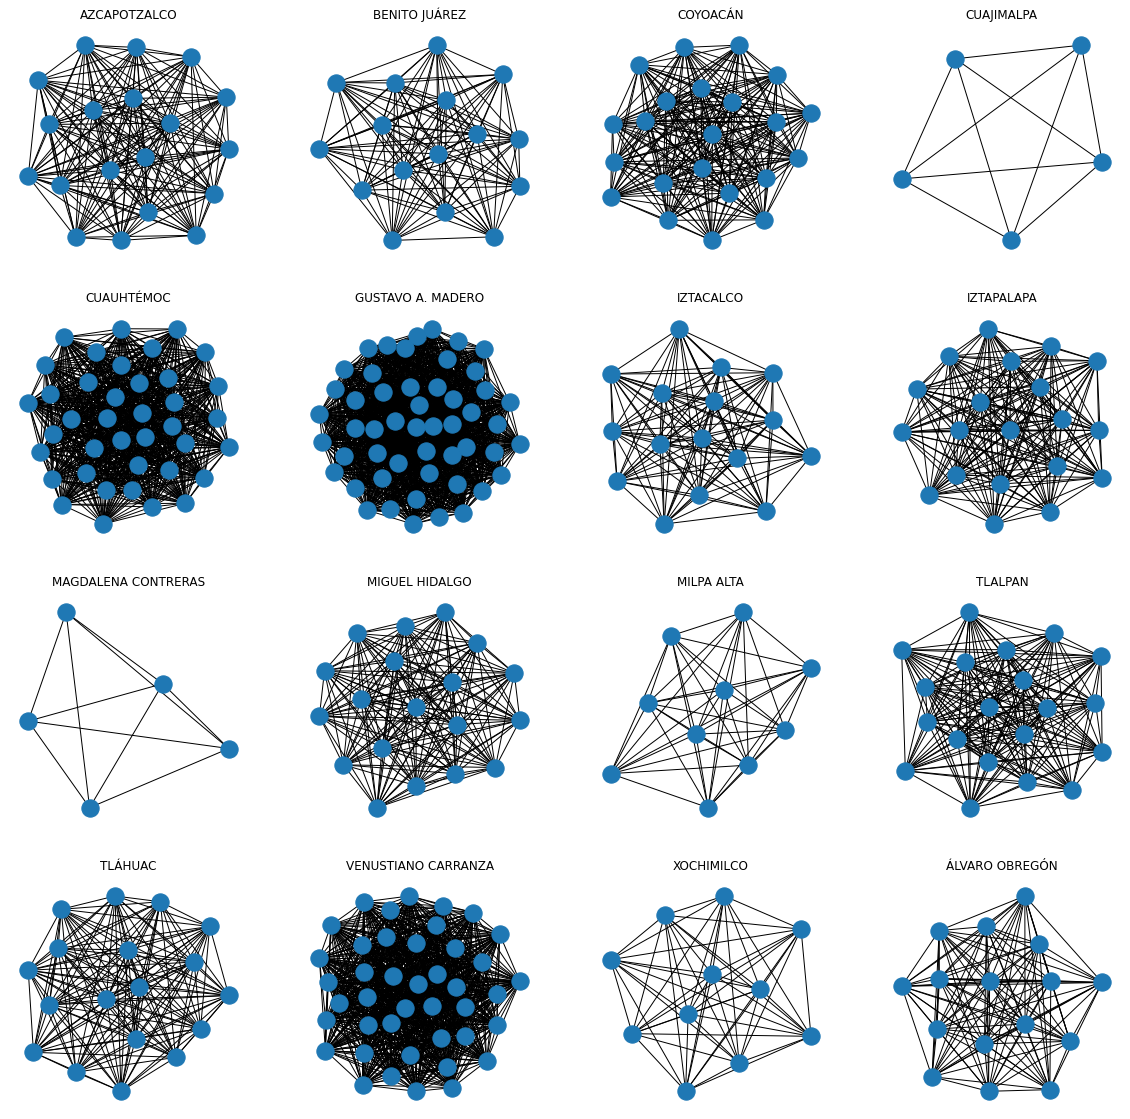

In [ ]:
fig, ax = plt.subplots(4,4,figsize=(20,20))
i = 1
for j, nombre_delegacion in enumerate(graficas_cdmx):    
    
    # Para usar los subplots con los indices correctos.
    if j >= 4*i:        
        i += 1
    
    ax[i-1][j%4].set_title(nombre_delegacion)
    nx.draw(graficas_cdmx[nombre_delegacion], ax=ax[i-1, j%4])           

Con esta paranamica podemos observar la distribución de los diferentes mercados de la Ciudad de mexico. Como hemos anteriormente deseamos conocer la ruta más optima que pase por cada uno de los mercados, para eso decidimos utilizar el algortimo creado anteriormente con la modelo greedy dado que nuestro conjunto de entrada no es tan grande por cada delegación, por lo tanto puede verse lineal si lo vemos con una lupa, por eso mismo hemos decidimo usarlos para la solución de nuestro problema.

Obtenemos las rutas optimizadas: 

In [ ]:
rutas_optimas_delegacion = {}

for nombre_del, grafica_del in graficas_cdmx.items():
    nodo_inicial = list(grafica_del.nodes)[0]
    ruta_optima = ruta_optima_greedy(nodo_inicial,grafica_del)
    rutas_optimas_delegacion[nombre_del] = ruta_optima

Obtenemos las graficas de los caminos que pasa por todos los mercados: 

In [ ]:
G_rutas_optimas_del = {}
for nombre_del, ruta_optima_delegacion in rutas_optimas_delegacion.items():
    G_ruta_optima_del = nx.Graph()
    G_ruta_optima_del.add_weighted_edges_from(ruta_optima_delegacion)
    G_rutas_optimas_del[nombre_del] = G_ruta_optima_del    

Graficamos las rutas de cada delegación:

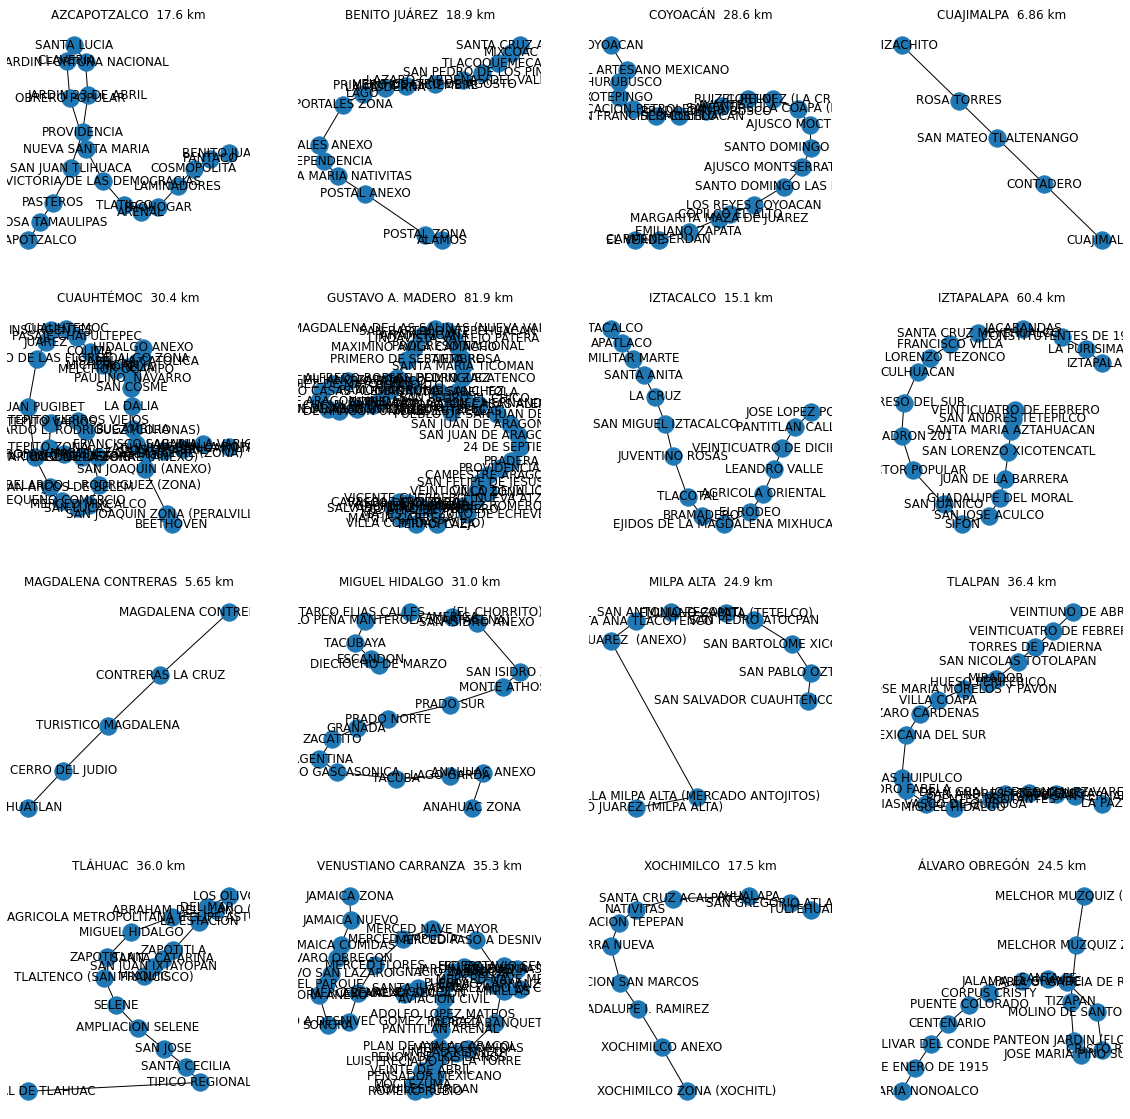

In [ ]:
fig, ax = plt.subplots(4,4,figsize=(20,20))
i = 1
for j, nombre_delegacion in enumerate(G_rutas_optimas_del):    
    
    # Para usar los subplots con los indices correctos.
    if j >= 4*i:        
        i += 1
    
    ax[i-1][j%4].set_title(nombre_delegacion + ' {:5.3} km'.format(obtener_peso_total(G_rutas_optimas_del[nombre_delegacion])))
    nx.draw(G_rutas_optimas_del[nombre_delegacion], with_labels=True, ax=ax[i-1, j%4])           


Para concluir vemos que este problema tambien conocido como problema del agente viajero no es tan facil como parece, ya que puede resultar encontrar la solución en un tiempo muy extension encontrando la mejor solución, como vimos si queremos encontrar la mejor solución se requiere tecnicas de programación dimica para reducir el espacio de estados, ya que si utilizamos solamente backtrack esto tardaria $O(!n)$ de tiempo, por lo que no resultaria util, decidimos utilizar el algoritmo greedy por eficacio en nuestra datos ya que los resultados que nos devuelve son rapidos, tal vez no sea la más optima, pero como mencionamos anteriormente es un problema NP-dificil que puede dartas mucho tiempo para encontrar la mejor solución.
